In [1]:
# just trying a plain network to see if it converges faster

In [2]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [5]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [308]:
def get_uncompiled_custom_model(
    input_shape,
    output_shape,
    units,
    activation,
    n_blocks,
    layers_per_block,
    skip_connection=False,
    plain_network=False
):
    input_layer = tf.keras.Input(shape=(input_shape,))

    outputs = []

    x = tf.keras.layers.Dense(units, activation=activation)(input_layer)

    for k in range(n_blocks):
        if skip_connection:
            tmp = x
        for j in range(layers_per_block):
            x = tf.keras.layers.Dense(units, activation=activation)(x)
        if skip_connection:
            x = tf.keras.layers.add([x, tmp])
        outputs.append(tf.keras.layers.Dense(output_shape)(x))
    if plain_network:
#         outputs = tf.keras.layers.Dense(output_shape)(x)
        outputs = outputs[-1]
    else:
        outputs = tf.keras.layers.add([output for output in outputs])

    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)
    return model

def get_compiled_custom_model(model_params_dict, lr, loss='mse'):
    model = get_uncompiled_custom_model(**model_params_dict)

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer)

    return model

# load data

In [8]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

X_train_raw = np.float32(X_train_raw)
y_train_raw = np.float32(y_train_raw)

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:2].reshape(-1, 2)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")



# X_train = np.float32(X_train_raw)
# y_train = np.float32(y_train)
# X_val = np.float32(X_val)
# y_val = np.float32(y_val)

X_train_raw.shape: (1119, 2)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 2)
y_train.shape: (749, 1)
X_val.shape: (370, 2)
y_val.shape: (370, 1)


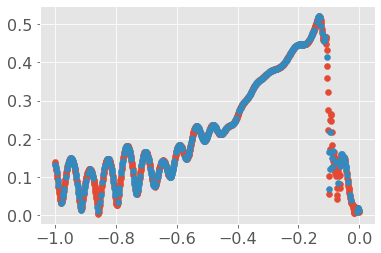

In [9]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_val[:,0], y_val)

# create tf datasets

# base line

In [333]:
model_params_dict = dict(
    input_shape=2,
    output_shape=1,
    units=128,
    activation='relu',
    n_blocks=2,
    layers_per_block=2,
    skip_connection=False,
    plain_network=False
)

In [334]:
test_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=1e-3)

In [335]:
test_model.summary()

Model: "model_143"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_145 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_3345 (Dense)              (None, 128)          384         input_145[0][0]                  
__________________________________________________________________________________________________
dense_3346 (Dense)              (None, 128)          16512       dense_3345[0][0]                 
__________________________________________________________________________________________________
dense_3347 (Dense)              (None, 128)          16512       dense_3346[0][0]                 
__________________________________________________________________________________________

In [336]:
# tf.keras.utils.plot_model(custom_model)

In [337]:
callbacks = [
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    wispy.callbacks.ThresholdCallback(1e-6),
    tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5, patience=100)
]

In [338]:
%%time
test_history = test_model.fit(x=X_train, y=y_train, epochs=2001, validation_data=(X_val, y_val), verbose=0, batch_size=200, callbacks=callbacks)

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

CPU times: user 2min 24s, sys: 17.7 s, total: 2min 41s
Wall time: 2min 37s


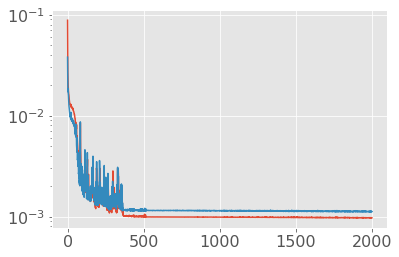

In [339]:
plt.figure()
plt.plot(test_history.history['loss'])
plt.plot(test_history.history['val_loss'])
plt.yscale('log')

In [340]:
test_yhat = test_model.predict(X_train)

In [341]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], test_yhat)
# plt.xlim(-0.2, 0)

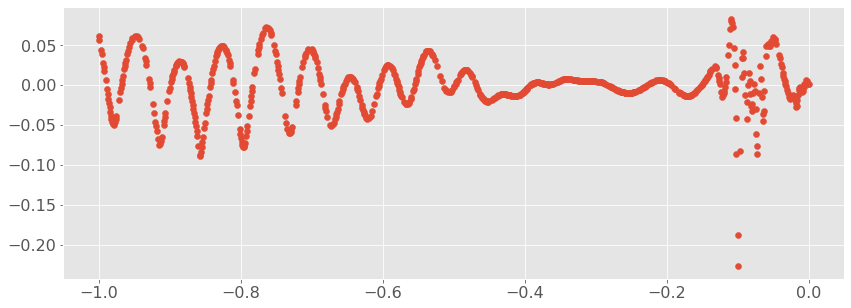

In [342]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-test_yhat)

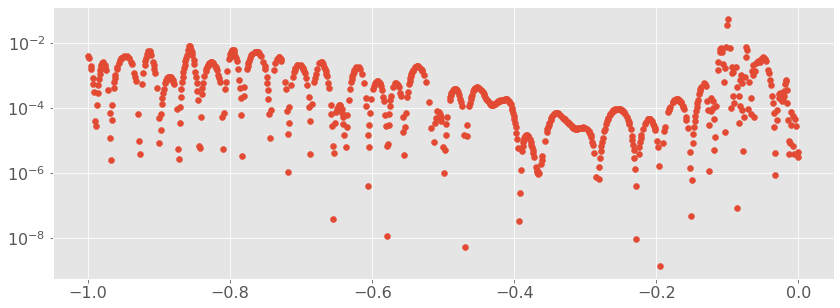

In [343]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,test_yhat))
plt.yscale('log')

# looping

## plain networks

In [320]:
%%time
plain_models = []
plain_historys = []
n_tries = 5
lr = 1e-3
batch_size = 749
epochs = 1001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=8,
        layers_per_block=3,
        skip_connection=False,
        plain_network=True
    )
    plain_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
    plain_history = plain_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    plain_models.append(plain_model)
    plain_historys.append(plain_history)


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 20%|██        | 1/5 [01:11<04:44, 71.02s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 40%|████      | 2/5 [02:16<03:23, 67.81s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 60%|██████    | 3/5 [03:21<02:12, 66.35s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 80%|████████  | 4/5 [04:25<01:05, 65.58s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


100%|██████████| 5/5 [05:32<00:00, 66.48s/it]

CPU times: user 9min 26s, sys: 1min 32s, total: 10min 59s
Wall time: 5min 32s


Text(0.5, 1.0, 'val')

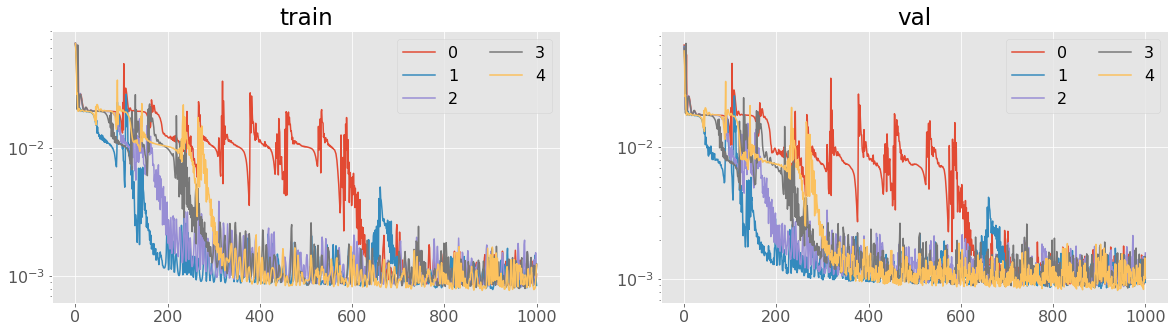

In [321]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

## plain networks with skip_connections

In [322]:
%%time
plain_skip_models = []
plain_skip_historys = []
n_tries = 5
lr = 1e-3
batch_size = 749
epochs = 1001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=8,
        layers_per_block=3,
        skip_connection=True,
        plain_network=True
    )
    plain_skip_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
    plain_skip_history = plain_skip_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    plain_skip_models.append(plain_skip_model)
    plain_skip_historys.append(plain_skip_history)


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 20%|██        | 1/5 [01:11<04:44, 71.09s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 40%|████      | 2/5 [02:21<03:31, 70.40s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 60%|██████    | 3/5 [03:30<02:19, 69.93s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 80%|████████  | 4/5 [04:39<01:09, 69.58s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


100%|██████████| 5/5 [05:47<00:00, 69.53s/it]

CPU times: user 9min 41s, sys: 1min 59s, total: 11min 40s
Wall time: 5min 47s


Text(0.5, 1.0, 'val')

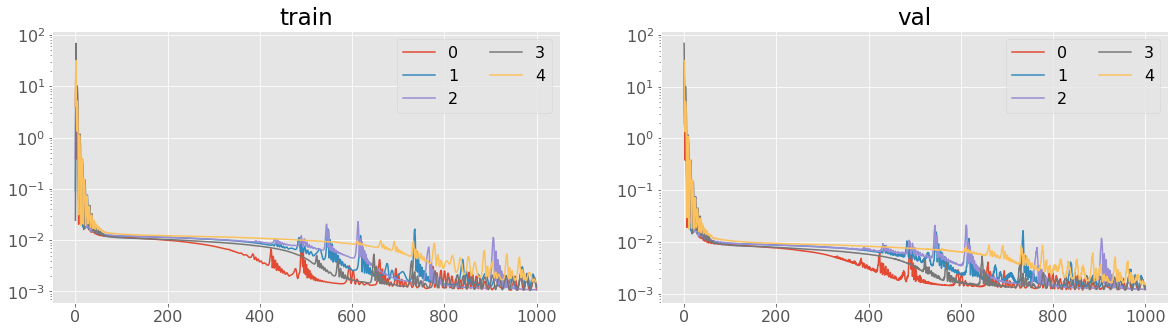

In [323]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

## not plain networks

In [324]:
%%time
custom_models = []
custom_historys = []
n_tries = 5
lr = 1e-3
batch_size = 749
epochs = 1001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=8,
        layers_per_block=3,
        skip_connection=False,
        plain_network=False
    )
    custom_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
    custom_history = custom_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    custom_models.append(custom_model)
    custom_historys.append(custom_history)


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 20%|██        | 1/5 [01:10<04:43, 70.79s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 40%|████      | 2/5 [02:23<03:35, 71.94s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 60%|██████    | 3/5 [03:37<02:25, 72.98s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 80%|████████  | 4/5 [04:50<01:12, 72.95s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


100%|██████████| 5/5 [06:02<00:00, 72.57s/it]

CPU times: user 10min 7s, sys: 1min 58s, total: 12min 5s
Wall time: 6min 2s


In [325]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(custom_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(custom_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

Text(0.5, 1.0, 'val')

## not plain networks with skip_connections

In [326]:
%%time
custom_skip_models = []
custom_skip_historys = []
n_tries = 5
lr = 1e-3
batch_size = 749
epochs = 1001
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=128,
        activation='relu',
        n_blocks=8,
        layers_per_block=3,
        skip_connection=True,
        plain_network=False
    )
    custom_skip_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)
    callbacks = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
    custom_skip_history = custom_skip_model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    custom_skip_models.append(custom_skip_model)
    custom_skip_historys.append(custom_skip_history)


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 20%|██        | 1/5 [01:15<05:01, 75.32s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 40%|████      | 2/5 [02:30<03:45, 75.31s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 60%|██████    | 3/5 [03:40<02:25, 72.87s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


 80%|████████  | 4/5 [04:51<01:12, 72.29s/it]

Training:   0%|           0/1001 ETA: ?s,  ?epochs/s


100%|██████████| 5/5 [06:02<00:00, 72.43s/it]

CPU times: user 10min 5s, sys: 2min 16s, total: 12min 21s
Wall time: 6min 2s


Text(0.5, 1.0, 'val')

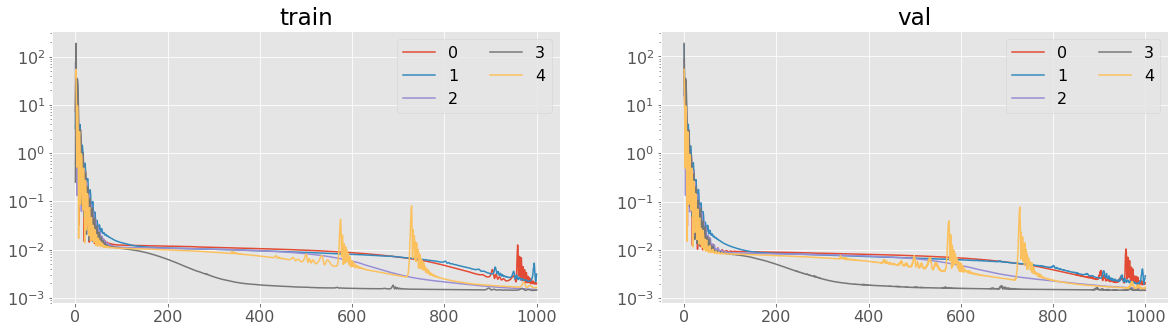

In [327]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

## comparison

Text(0.5, 1.0, 'train')

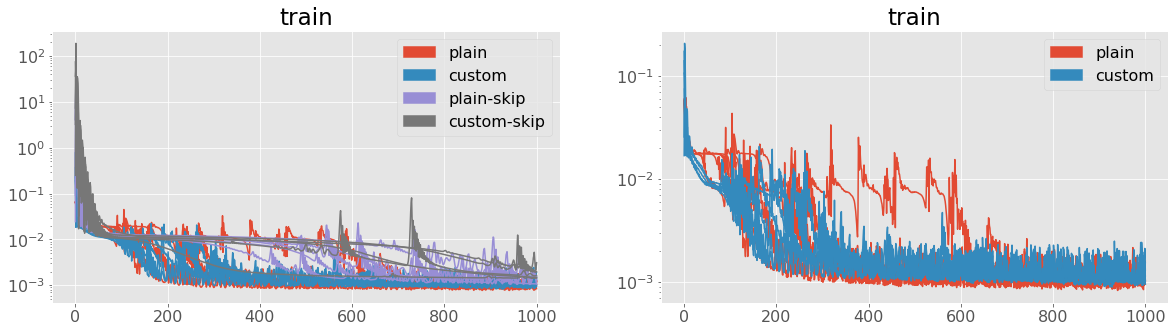

In [328]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['loss'], c='C1')
for i, history in enumerate(plain_skip_historys):
    plt.plot(history.history['loss'], c='C2')
for i, history in enumerate(custom_skip_historys):
    plt.plot(history.history['loss'], c='C3')
plt.yscale('log')
plt.legend(handles=[
    mpatches.Patch(color='C0', label='plain'),
    mpatches.Patch(color='C1', label='custom'),
    mpatches.Patch(color='C2', label='plain-skip'),
    mpatches.Patch(color='C3', label='custom-skip')])
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(plain_historys):
    plt.plot(history.history['val_loss'], c='C0')
for i, history in enumerate(custom_historys):
    plt.plot(history.history['val_loss'], c='C1')
plt.yscale('log')
plt.legend(handles=[mpatches.Patch(color='C0', label='plain'), mpatches.Patch(color='C1', label='custom')])
plt.title('train')

### conclusion

In [329]:
best_idx = np.argmin([history.history['loss'][-1] for history in custom_historys])
print(best_idx)

0


In [330]:
worst_idx = np.argmax([history.history['loss'][-1] for history in custom_historys])
print(worst_idx)

1


In [331]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], custom_models[worst_idx].predict(X_train), label='worst')
plt.scatter(X_train[:,0], custom_models[best_idx].predict(X_train), label='best')
# plt.xlim(-0.2, 0)
plt.legend()

In [332]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
for c_model in custom_models:
    plt.scatter(X_train[:,0], c_model.predict(X_train), c='k', alpha=0.2)
# plt.xlim(-0.2, 0)